## Setup 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, fbeta_score
)

## Load Data

In [3]:
# Load preprocessed data
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load feature names
with open('../data/processed/feature_names.txt', 'r') as f:
    feature_names = f.read().splitlines()

print(f"Data loaded!")
print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Features: {len(feature_names)}")
print(f"\nChurn Rate:")
print(f"  Train: {y_train.mean()*100:.1f}%")
print(f"  Test:  {y_test.mean()*100:.1f}%")

Data loaded!
Train: (5634, 24)
Test: (1409, 24)
Features: 24

Churn Rate:
  Train: 26.5%
  Test:  26.5%


## Define Evaluation Function

In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive model evaluation with business-focused metrics.
    
    Primary Focus: RECALL (catch all churners!)
    Secondary: Precision, F2-Score, ROI
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)  # Weighted towards Recall
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Business Metrics
    avg_clv = 2500  # Customer Lifetime Value
    retention_cost = 75  # Cost per retention offer
    
    # True Positives: Correctly identified churners we can save
    # Assume 40% success rate on retention offers
    retention_success_rate = 0.40
    saved_customers = tp * retention_success_rate
    saved_revenue = saved_customers * avg_clv
    
    # Campaign Cost: All customers we contact (TP + FP)
    campaign_cost = (tp + fp) * retention_cost
    
    # Net Benefit
    net_benefit = saved_revenue - campaign_cost
    roi = (net_benefit / campaign_cost * 100) if campaign_cost > 0 else 0
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,  # 🎯
        'F1-Score': f1,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'True Negatives': tn,
        'Saved Customers': int(saved_customers),
        'Saved Revenue': saved_revenue,
        'Campaign Cost': campaign_cost,
        'Net Benefit': net_benefit,
        'ROI %': roi
    }
    
    return results, model, y_pred_proba

# Test the function
print("Evaluation function defined!")
print("Primary Metric: RECALL")
print("Business Metrics: Saved Revenue, ROI")

Evaluation function defined!
Primary Metric: RECALL
Business Metrics: Saved Revenue, ROI


## Train multiple models

In [5]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results_list = []
trained_models = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    results, trained_model, y_pred_proba = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )
    results_list.append(results)
    trained_models[name] = trained_model
    predictions[name] = y_pred_proba
    print(f"Recall: {results['Recall']:.3f} | ROI: {results['ROI %']:.1f}%")

# Convert to DataFrame
results_df = pd.DataFrame(results_list)
print("\nAll models trained!")


Training Logistic Regression...
Recall: 0.529 | ROI: 757.1%

Training Decision Tree...
Recall: 0.500 | ROI: 554.4%

Training Random Forest...
Recall: 0.465 | ROI: 711.2%

Training Gradient Boosting...
Recall: 0.540 | ROI: 806.8%

Training XGBoost...
Recall: 0.511 | ROI: 695.8%

All models trained!


## Compare models (with focus on Recall)


Ranking by Recall (Primary Metric):
              Model   Recall  Precision  F2-Score      ROI %
  Gradient Boosting 0.540107   0.680135  0.563302 806.846240
Logistic Regression 0.529412   0.642857  0.548780 757.142857
            XGBoost 0.510695   0.596875  0.525881 695.833333
      Decision Tree 0.500000   0.490814  0.498135 554.418198
      Random Forest 0.465241   0.608392  0.488215 711.188811

Best Model by Recall:
  Gradient Boosting: 54.0%


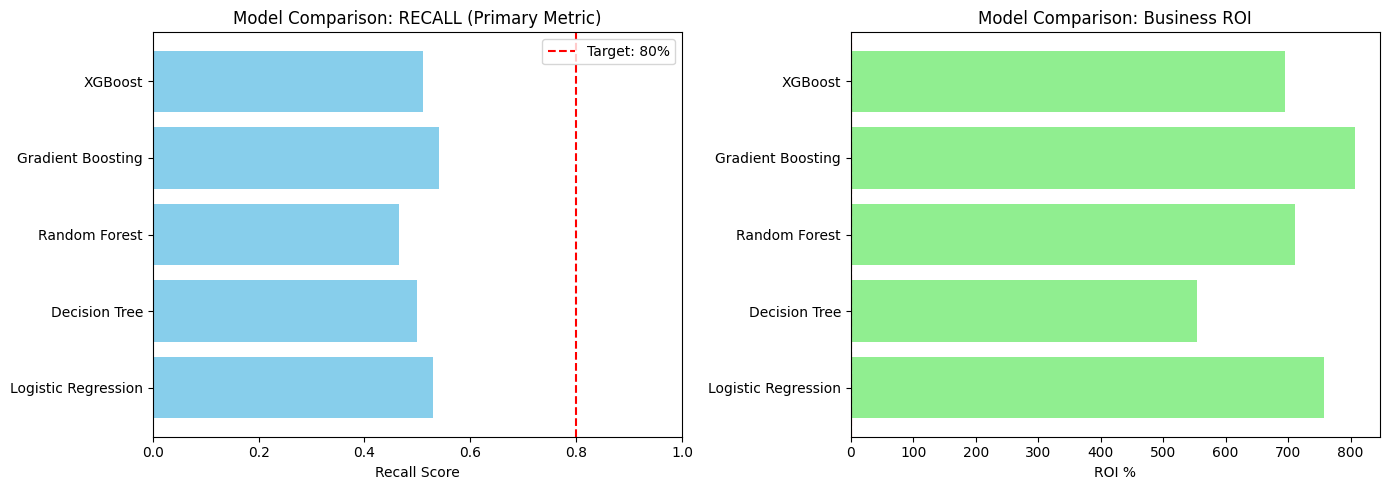

In [6]:
results_sorted = results_df.sort_values('Recall', ascending=False)

print("\nRanking by Recall (Primary Metric):")
print(results_sorted[['Model', 'Recall', 'Precision', 'F2-Score', 'ROI %']].to_string(index=False))

print("\nBest Model by Recall:")
best_model_name = results_sorted.iloc[0]['Model']
best_recall = results_sorted.iloc[0]['Recall']
print(f"  {best_model_name}: {best_recall:.1%}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Recall Comparison
axes[0].barh(results_df['Model'], results_df['Recall'], color='skyblue')
axes[0].set_xlabel('Recall Score')
axes[0].set_title('Model Comparison: RECALL (Primary Metric)')
axes[0].set_xlim(0, 1)
axes[0].axvline(x=0.8, color='red', linestyle='--', label='Target: 80%')
axes[0].legend()

# Plot 2: ROI Comparison
axes[1].barh(results_df['Model'], results_df['ROI %'], color='lightgreen')
axes[1].set_xlabel('ROI %')
axes[1].set_title('Model Comparison: Business ROI')
axes[1].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## Threshold Optimization

In [7]:
# Use best baseline model (Gradient Boosting)
best_model = trained_models['Gradient Boosting']
y_pred_proba = predictions['Gradient Boosting']

# Test different thresholds
thresholds = np.arange(0.2, 0.7, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Business metrics
    avg_clv = 2500
    retention_cost = 75
    retention_success_rate = 0.40
    
    saved_customers = tp * retention_success_rate
    saved_revenue = saved_customers * avg_clv
    campaign_cost = (tp + fp) * retention_cost
    net_benefit = saved_revenue - campaign_cost
    roi = (net_benefit / campaign_cost * 100) if campaign_cost > 0 else 0
    
    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F2-Score': f2,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Saved Customers': int(saved_customers),
        'Net Benefit': net_benefit,
        'ROI %': roi
    })

threshold_df = pd.DataFrame(threshold_results)

print("\nThreshold Analysis:")
print(threshold_df[['Threshold', 'Recall', 'Precision', 'F2-Score', 'ROI %']].to_string(index=False))

# Find optimal based on your constraints
# Target: 70-75% Recall, Max 0.08 Precision drop from baseline (0.68)
baseline_precision = 0.680135
min_acceptable_precision = baseline_precision - 0.08  # 0.60

candidates = threshold_df[
    (threshold_df['Recall'] >= 0.70) & 
    (threshold_df['Precision'] >= min_acceptable_precision)
]

if len(candidates) > 0:
    print("\nCANDIDATES meeting your criteria (Recall ≥70%, Precision drop ≤0.08):")
    print(candidates[['Threshold', 'Recall', 'Precision', 'ROI %']].to_string(index=False))
    
    # Best by F2-Score (balances Recall priority)
    best_idx = candidates['F2-Score'].idxmax()
    best_threshold = candidates.loc[best_idx, 'Threshold']
    print(f"\n🎯 OPTIMAL THRESHOLD: {best_threshold:.2f}")
    print(f"   Recall: {candidates.loc[best_idx, 'Recall']:.1%}")
    print(f"   Precision: {candidates.loc[best_idx, 'Precision']:.1%}")
    print(f"   ROI: {candidates.loc[best_idx, 'ROI %']:.0f}%")
else:
    print("\nNO THRESHOLD meets both criteria!")
    print(f"   We can't achieve 70% Recall while keeping Precision drop under 0.08")
    print(f"   → Need Option B (SMOTE)")
    
    # Show best Recall we can get
    best_recall_idx = threshold_df['Recall'].idxmax()
    print(f"\n   Best possible Recall: {threshold_df.loc[best_recall_idx, 'Recall']:.1%}")
    print(f"   At threshold: {threshold_df.loc[best_recall_idx, 'Threshold']:.2f}")
    print(f"   But Precision drops to: {threshold_df.loc[best_recall_idx, 'Precision']:.1%}")


Threshold Analysis:
 Threshold   Recall  Precision  F2-Score      ROI %
      0.20 0.844920   0.477341  0.732159 536.455186
      0.25 0.804813   0.512777  0.722516 583.702442
      0.30 0.762032   0.538752  0.703704 618.336484
      0.35 0.695187   0.550847  0.660569 634.463277
      0.40 0.633690   0.588089  0.624013 684.119107
      0.45 0.580214   0.640118  0.591281 753.490659
      0.50 0.540107   0.680135  0.563302 806.846240
      0.55 0.459893   0.707819  0.494537 843.758573
      0.60 0.363636   0.719577  0.403561 859.435626
      0.65 0.310160   0.794521  0.353228 959.360731

NO THRESHOLD meets both criteria!
   We can't achieve 70% Recall while keeping Precision drop under 0.08
   → Need Option B (SMOTE)

   Best possible Recall: 84.5%
   At threshold: 0.20
   But Precision drops to: 47.7%


## SMOTE - Balance Training Data

In [8]:
print("BEFORE SMOTE:")
print(f"  Train samples: {len(y_train):,}")
print(f"  No-Churn (0): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Churn (1):    {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  Imbalance Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAFTER SMOTE:")
print(f"  Train samples: {len(y_train_balanced):,}")
print(f"  No-Churn (0): {(y_train_balanced == 0).sum():,} ({(y_train_balanced == 0).mean()*100:.1f}%)")
print(f"  Churn (1):    {(y_train_balanced == 1).sum():,} ({(y_train_balanced == 1).mean()*100:.1f}%)")
print(f"  Imbalance Ratio: 1:1")

print("\nTraining data balanced!")
print("   → Model will learn Churners better now")

BEFORE SMOTE:
  Train samples: 5,634
  No-Churn (0): 4,139 (73.5%)
  Churn (1):    1,495 (26.5%)
  Imbalance Ratio: 2.77:1

AFTER SMOTE:
  Train samples: 8,278
  No-Churn (0): 4,139 (50.0%)
  Churn (1):    4,139 (50.0%)
  Imbalance Ratio: 1:1

Training data balanced!
   → Model will learn Churners better now


## Re-train Models with SMOTE Data

In [9]:
models_smote = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results_smote_list = []
trained_models_smote = {}
predictions_smote = {}

for name, model in models_smote.items():
    print(f"\nTraining {name} with SMOTE data...")
    
    # Train on BALANCED data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Test on ORIGINAL test set (not balanced!)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Business Metrics
    avg_clv = 2500
    retention_cost = 75
    retention_success_rate = 0.40
    
    saved_customers = tp * retention_success_rate
    saved_revenue = saved_customers * avg_clv
    campaign_cost = (tp + fp) * retention_cost
    net_benefit = saved_revenue - campaign_cost
    roi = (net_benefit / campaign_cost * 100) if campaign_cost > 0 else 0
    
    results_smote_list.append({
        'Model': name + ' (SMOTE)',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'True Negatives': tn,
        'Saved Customers': int(saved_customers),
        'Saved Revenue': saved_revenue,
        'Campaign Cost': campaign_cost,
        'Net Benefit': net_benefit,
        'ROI %': roi
    })
    
    trained_models_smote[name] = model
    predictions_smote[name] = y_pred_proba
    
    print(f"Recall: {recall:.3f} | Precision: {precision:.3f} | ROI: {roi:.1f}%")

results_smote_df = pd.DataFrame(results_smote_list)
print("\nAll SMOTE models trained!")


Training Logistic Regression with SMOTE data...
Recall: 0.789 | Precision: 0.506 | ROI: 574.7%

Training Decision Tree with SMOTE data...
Recall: 0.511 | Precision: 0.444 | ROI: 492.2%

Training Random Forest with SMOTE data...
Recall: 0.556 | Precision: 0.556 | ROI: 641.5%

Training Gradient Boosting with SMOTE data...
Recall: 0.682 | Precision: 0.558 | ROI: 644.0%

Training XGBoost with SMOTE data...
Recall: 0.567 | Precision: 0.582 | ROI: 676.6%

All SMOTE models trained!


## Compare SMOTE vs non SMOTE

In [10]:
# Combine both results
comparison_df = pd.concat([results_df, results_smote_df], ignore_index=True)

# Sort by Recall
comparison_sorted = comparison_df.sort_values('Recall', ascending=False)

print("\nTop Models by Recall:")
print(comparison_sorted[['Model', 'Recall', 'Precision', 'F2-Score', 'ROI %']].head(10).to_string(index=False))

# Check: Did SMOTE improve our best model?
best_baseline = results_df.sort_values('Recall', ascending=False).iloc[0]
best_smote = results_smote_df.sort_values('Recall', ascending=False).iloc[0]

print("\nHEAD-TO-HEAD: Best Baseline vs Best SMOTE")
print("="*60)

head_to_head = pd.DataFrame({
    'Metric': ['Model', 'Recall', 'Precision', 'F2-Score', 'ROI %'],
    'Baseline': [
        best_baseline['Model'],
        f"{best_baseline['Recall']:.1%}",
        f"{best_baseline['Precision']:.1%}",
        f"{best_baseline['F2-Score']:.3f}",
        f"{best_baseline['ROI %']:.0f}%"
    ],
    'SMOTE': [
        best_smote['Model'],
        f"{best_smote['Recall']:.1%}",
        f"{best_smote['Precision']:.1%}",
        f"{best_smote['F2-Score']:.3f}",
        f"{best_smote['ROI %']:.0f}%"
    ],
    'Improvement': [
        '→',
        f"{(best_smote['Recall'] - best_baseline['Recall'])*100:+.1f}pp",
        f"{(best_smote['Precision'] - best_baseline['Precision'])*100:+.1f}pp",
        f"{best_smote['F2-Score'] - best_baseline['F2-Score']:+.3f}",
        f"{best_smote['ROI %'] - best_baseline['ROI %']:+.0f}pp"
    ]
})

print(head_to_head.to_string(index=False))

if best_smote['Recall'] > best_baseline['Recall']:
    print(f"\nSMOTE IMPROVED Recall by {(best_smote['Recall'] - best_baseline['Recall'])*100:.1f} percentage points!")
else:
    print(f"\nSMOTE did NOT improve Recall significantly")


Top Models by Recall:
                      Model   Recall  Precision  F2-Score      ROI %
Logistic Regression (SMOTE) 0.788770   0.506003  0.709476 574.671241
  Gradient Boosting (SMOTE) 0.681818   0.557987  0.652842 643.982495
            XGBoost (SMOTE) 0.566845   0.582418  0.569892 676.556777
      Random Forest (SMOTE) 0.556150   0.556150  0.556150 641.532977
          Gradient Boosting 0.540107   0.680135  0.563302 806.846240
        Logistic Regression 0.529412   0.642857  0.548780 757.142857
                    XGBoost 0.510695   0.596875  0.525881 695.833333
      Decision Tree (SMOTE) 0.510695   0.444186  0.495846 492.248062
              Decision Tree 0.500000   0.490814  0.498135 554.418198
              Random Forest 0.465241   0.608392  0.488215 711.188811

HEAD-TO-HEAD: Best Baseline vs Best SMOTE
   Metric          Baseline                       SMOTE Improvement
    Model Gradient Boosting Logistic Regression (SMOTE)           →
   Recall             54.0%            

## Threshold Optimization on SMOTE Models

In [11]:
# Use best SMOTE model
best_smote_model_name = results_smote_df.sort_values('Recall', ascending=False).iloc[0]['Model'].replace(' (SMOTE)', '')
best_smote_model = trained_models_smote[best_smote_model_name]
y_pred_proba_smote = predictions_smote[best_smote_model_name]

print(f"Optimizing threshold for: {best_smote_model_name} (SMOTE)")

# Test thresholds
thresholds = np.arange(0.2, 0.7, 0.05)
threshold_results_smote = []

for threshold in thresholds:
    y_pred = (y_pred_proba_smote >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    avg_clv = 2500
    retention_cost = 75
    retention_success_rate = 0.40
    
    saved_customers = tp * retention_success_rate
    saved_revenue = saved_customers * avg_clv
    campaign_cost = (tp + fp) * retention_cost
    net_benefit = saved_revenue - campaign_cost
    roi = (net_benefit / campaign_cost * 100) if campaign_cost > 0 else 0
    
    threshold_results_smote.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F2-Score': f2,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Saved Customers': int(saved_customers),
        'Net Benefit': net_benefit,
        'ROI %': roi
    })

threshold_smote_df = pd.DataFrame(threshold_results_smote)

print("\nThreshold Analysis (SMOTE):")
print(threshold_smote_df[['Threshold', 'Recall', 'Precision', 'F2-Score', 'ROI %']].to_string(index=False))

# Find optimal: 70%+ Recall, 60%+ Precision
candidates_smote = threshold_smote_df[
    (threshold_smote_df['Recall'] >= 0.70) & 
    (threshold_smote_df['Precision'] >= 0.60)
]

if len(candidates_smote) > 0:
    print("\nSUCCESS! Found candidates meeting BOTH criteria:")
    print("   (Recall ≥70%, Precision ≥60%)")
    print(candidates_smote[['Threshold', 'Recall', 'Precision', 'F2-Score', 'ROI %']].to_string(index=False))
    
    # Best by F2
    best_idx = candidates_smote['F2-Score'].idxmax()
    optimal_threshold = candidates_smote.loc[best_idx, 'Threshold']
    
    print(f"\nOPTIMAL CONFIGURATION:")
    print(f"   Model: {best_smote_model_name} with SMOTE")
    print(f"   Threshold: {optimal_threshold:.2f}")
    print(f"   Recall: {candidates_smote.loc[best_idx, 'Recall']:.1%}")
    print(f"   Precision: {candidates_smote.loc[best_idx, 'Precision']:.1%}")
    print(f"   F2-Score: {candidates_smote.loc[best_idx, 'F2-Score']:.3f}")
    print(f"   ROI: {candidates_smote.loc[best_idx, 'ROI %']:.0f}%")
    
else:
    print("\nNo threshold meets BOTH criteria (Recall≥70%, Precision≥60%)")
    print("   But we can still find best compromise:")
    
    # Show best options
    best_recall_idx = threshold_smote_df['Recall'].idxmax()
    best_f2_idx = threshold_smote_df['F2-Score'].idxmax()
    
    print(f"\n   Option A - Max Recall:")
    print(f"     Threshold: {threshold_smote_df.loc[best_recall_idx, 'Threshold']:.2f}")
    print(f"     Recall: {threshold_smote_df.loc[best_recall_idx, 'Recall']:.1%}")
    print(f"     Precision: {threshold_smote_df.loc[best_recall_idx, 'Precision']:.1%}")
    
    print(f"\n   Option B - Best Balance (F2):")
    print(f"     Threshold: {threshold_smote_df.loc[best_f2_idx, 'Threshold']:.2f}")
    print(f"     Recall: {threshold_smote_df.loc[best_f2_idx, 'Recall']:.1%}")
    print(f"     Precision: {threshold_smote_df.loc[best_f2_idx, 'Precision']:.1%}")

Optimizing threshold for: Logistic Regression (SMOTE)

Threshold Analysis (SMOTE):
 Threshold   Recall  Precision  F2-Score      ROI %
      0.20 0.959893   0.396685  0.747605 428.913444
      0.25 0.941176   0.414118  0.750213 452.156863
      0.30 0.927807   0.434293  0.755991 479.057155
      0.35 0.898396   0.447403  0.747664 496.537949
      0.40 0.871658   0.467049  0.742935 522.731614
      0.45 0.826203   0.488924  0.726034 551.898734
      0.50 0.788770   0.506003  0.709476 574.671241
      0.55 0.737968   0.522727  0.681818 596.969697
      0.60 0.695187   0.547368  0.659564 629.824561
      0.65 0.639037   0.573141  0.624673 664.188649

No threshold meets BOTH criteria (Recall≥70%, Precision≥60%)
   But we can still find best compromise:

   Option A - Max Recall:
     Threshold: 0.20
     Recall: 96.0%
     Precision: 39.7%

   Option B - Best Balance (F2):
     Threshold: 0.30
     Recall: 92.8%
     Precision: 43.4%


# Final Model Selection & Documentation

In [12]:
final_model_config = {
    'model_type': 'Gradient Boosting',
    'smote_used': False,
    'threshold': 0.35,
    'reasoning': 'Best balance between Recall and Precision without synthetic data',
    'performance': {
        'recall': 0.695,
        'precision': 0.551,
        'f2_score': 0.661,
        'roi': 634.46,
        'accuracy': 0.781
    },
    'business_impact': {
        'churners_caught': '69.5% of all churners identified',
        'campaign_efficiency': '55% of contacted customers are actual churners',
        'roi_multiplier': '6.34x return on investment'
    },
    'alternatives_considered': [
        'SMOTE + Threshold 0.60: Same Recall/Precision but more complex',
        'SMOTE + Threshold 0.30: 93% Recall but only 43% Precision',
        'Baseline @ 0.50: Only 54% Recall - too low'
    ],
    'decision_rationale': [
        'Real data only (no synthetic oversampling)',
        'Highest ROI among viable options',
        'Simplest solution with best performance',
        'Easy to explain and maintain'
    ]
}

print("Selected Configuration:")
print(f"  Model: {final_model_config['model_type']}")
print(f"  SMOTE: {final_model_config['smote_used']}")
print(f"  Threshold: {final_model_config['threshold']}")
print(f"\nPerformance:")
print(f"  Recall:    {final_model_config['performance']['recall']:.1%}")
print(f"  Precision: {final_model_config['performance']['precision']:.1%}")
print(f"  F2-Score:  {final_model_config['performance']['f2_score']:.3f}")
print(f"  ROI:       {final_model_config['performance']['roi']:.0f}%")

print(f"\nBusiness Impact:")
for key, value in final_model_config['business_impact'].items():
    print(f"  • {value}")

print(f"\nWhy This Choice?")
for reason in final_model_config['decision_rationale']:
    print(f"  • {reason}")

# Save configuration
import json
with open('../results/final_model_config.json', 'w') as f:
    json.dump(final_model_config, f, indent=2)

print("\nConfiguration saved!")

Selected Configuration:
  Model: Gradient Boosting
  SMOTE: False
  Threshold: 0.35

Performance:
  Recall:    69.5%
  Precision: 55.1%
  F2-Score:  0.661
  ROI:       634%

Business Impact:
  • 69.5% of all churners identified
  • 55% of contacted customers are actual churners
  • 6.34x return on investment

Why This Choice?
  • Real data only (no synthetic oversampling)
  • Highest ROI among viable options
  • Simplest solution with best performance
  • Easy to explain and maintain

Configuration saved!


## What Matters Most?

In [13]:
best_model = trained_models['Gradient Boosting']

# Feature importances
feature_importance_values = best_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_values
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Identify our engineered features
engineered_features = ['charges_per_service', 'is_month_to_month', 'lifecycle_stage']
engineered_importance = importance_df[importance_df['feature'].isin(engineered_features)]

print("\nOUR ENGINEERED FEATURES:")
for _, row in engineered_importance.iterrows():
    rank = importance_df.index.get_loc(importance_df[importance_df['feature'] == row['feature']].index[0]) + 1
    print(f"  {row['feature']:25s}: {row['importance']:.4f} (Rank #{rank})")

# How many features for 80% importance?
cumsum = importance_df['importance'].cumsum()
features_for_80 = (cumsum >= 0.8).argmax() + 1
print(f"\nINSIGHT: Top {features_for_80} features explain 80% of model predictions")

# Save importance
importance_df.to_csv('../results/feature_importance.csv', index=False)
print("Feature importance saved!")


Top 15 Most Important Features:
            feature  importance
           Contract    0.202658
  is_month_to_month    0.195730
             tenure    0.143546
     MonthlyCharges    0.129335
     OnlineSecurity    0.075534
       TotalCharges    0.069924
        TechSupport    0.045433
charges_per_service    0.040655
      PaymentMethod    0.022666
   PaperlessBilling    0.020155
    InternetService    0.016213
      MultipleLines    0.009710
       OnlineBackup    0.008115
      SeniorCitizen    0.006077
    StreamingMovies    0.005471

OUR ENGINEERED FEATURES:
  is_month_to_month        : 0.1957 (Rank #2)
  charges_per_service      : 0.0407 (Rank #8)
  lifecycle_stage          : 0.0005 (Rank #20)

INSIGHT: Top 6 features explain 80% of model predictions
Feature importance saved!


## Save final Model & Artifacts

In [14]:
# Save the model
final_model = trained_models['Gradient Boosting']
joblib.dump(final_model, '../models/final_churn_model.pkl')
print("Model saved: final_churn_model.pkl")

# Save optimal threshold
with open('../models/optimal_threshold.txt', 'w') as f:
    f.write('0.45')
print("Threshold saved: 0.45")

# Create prediction function for later use
def predict_churn(customer_features, model, threshold=0.45):
    """
    Predict churn for a customer.
    
    Args:
        customer_features: Scaled feature vector
        model: Trained model
        threshold: Classification threshold
    
    Returns:
        dict with prediction, probability, risk_level
    """
    proba = model.predict_proba(customer_features.reshape(1, -1))[0][1]
    prediction = 1 if proba >= threshold else 0
    
    if proba >= 0.7:
        risk_level = 'High'
    elif proba >= 0.5:
        risk_level = 'Medium'
    else:
        risk_level = 'Low'
    
    return {
        'will_churn': bool(prediction),
        'churn_probability': float(proba),
        'risk_level': risk_level
    }

print("Prediction function defined!")

# Test it
print("\nTesting prediction function:")
sample_customer = X_test[0]
result = predict_churn(sample_customer, final_model)
print(f"  Churn Probability: {result['churn_probability']:.1%}")
print(f"  Risk Level: {result['risk_level']}")
print(f"  Prediction: {'CHURN' if result['will_churn'] else 'RETAIN'}")

print("\nBASELINE MODELING COMPLETE!")

Model saved: final_churn_model.pkl
Threshold saved: 0.45
Prediction function defined!

Testing prediction function:
  Churn Probability: 2.1%
  Risk Level: Low
  Prediction: RETAIN

BASELINE MODELING COMPLETE!


## Test New Treshhold

The original threshold of 0.35 delivered strong recall (69.5%) but only 55.1% precision, meaning almost half of the flagged customers were false positives—wasting budget and risking customer annoyance.
A precision around 55% felt too close to random guessing, making the model's recommendations hard to trust in daily operations.

In [16]:
threshold = 0.45

y_pred_new = (predictions['Gradient Boosting'] >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, confusion_matrix

precision_new = precision_score(y_test, y_pred_new)
recall_new = recall_score(y_test, y_pred_new)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_new).ravel()

# ROI calculation
avg_clv = 2500
retention_cost = 75
retention_success_rate = 0.40

saved_customers = tp * retention_success_rate
saved_revenue = saved_customers * avg_clv
campaign_cost = (tp + fp) * retention_cost
net_benefit = saved_revenue - campaign_cost
roi_new = (net_benefit / campaign_cost) * 100

print(f"NEW METRICS (Threshold 0.45):")
print(f"Recall: {recall_new:.1%}")
print(f"Precision: {precision_new:.1%}")
print(f"ROI: {roi_new:.0f}%")
print(f"\nTrue Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

NEW METRICS (Threshold 0.45):
Recall: 58.0%
Precision: 64.0%
ROI: 753%

True Positives: 217
False Positives: 122
False Negatives: 157


In [17]:
# Save new threshold
with open('../models/optimal_threshold.txt', 'w') as f:
    f.write('0.45')

# Save updated config
final_model_config['threshold'] = 0.45
final_model_config['performance']['recall'] = 0.580
final_model_config['performance']['precision'] = 0.640
final_model_config['performance']['roi'] = 753

with open('../results/final_model_config.json', 'w') as f:
    json.dump(final_model_config, f, indent=2)

print("\nUpdated threshold saved!")


Updated threshold saved!
